In [39]:
import os
import os.path as path
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
os.makedirs()
img_path = '../data/dataset/images'
txt_path = '../data/dataset/texts'

In [3]:
def extract_coordinate(file):
    with open(file, 'r') as f:
        data = f.read().splitlines()
        lines = [line.split(',')[:8] for line in data]
        return [[int(value) for value in line] for line in lines]

In [30]:
def create_map(img_size, boxes):
    '''
        img_size: (h, w)
        boxes[i]: x0, y0, x1, y1, x2, y2, x3, y3
    '''
    map_img = np.zeros(img_size)
    for i, box in enumerate(boxes):
        xmin, xmax = min(box[::2]), max(box[::2])
        ymin, ymax = min(box[1::2]), max(box[1::2])

        width_y = ymax - ymin
        y_center = (ymax + ymin) / 2
        M = lambda y: 1.0 / (2 * np.pi * width_y) * np.exp(-y**2 / (2 * width_y**2))
        for y in range(ymin, ymax, 1):
            map_img[y, xmin:xmax] = M(y - y_center)
    return map_img

In [33]:
img = Image.open(path.join(img_path, 'X51005306399.jpg'))
boxes = extract_coordinate(path.join(txt_path, 'X51005306399.txt'))
create_map([img.size[1], img.size[0]], boxes)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
img.size, img.size[::-1]

((447, 915), (915, 447))

In [44]:
def crop_data(size):
    images_path = '../data/dataset/images'
    txt_path = '../data/dataset/texts'
    crop_image_path = '../data/dataset/croped_images/images'
    crop_map_image_path = '../data/dataset/croped_images/map_images'
    crop = transforms.RandomCrop(size)
    n_loop = 100
    files = sorted(os.listdir(images_path))
    for img_file in tqdm(files):
        name = img_file[:-4]
        image = Image.open(os.path.join(images_path, img_file)).convert('RGB')
        image = torch.tensor(np.array(image))

        boxes = extract_coordinate(path.join(txt_path, f'{name}.txt'))
        map_image = create_map(image.shape[:2], boxes)
        map_image = torch.tensor(map_image)

        tensor_image = torch.cat([image, map_image.unsqueeze(2)], dim = 2)
        tensor_image = tensor_image.permute(2, 0, 1)

        for i in range(n_loop):
            cropedImage = crop(tensor_image)
            im = cropedImage[:3].permute(1, 2, 0).numpy()
            im = im.astype(np.uint8)
            
            Image.fromarray(im).save(os.path.join(crop_image_path, f'{name}_{i}.jpg'))
            torch.save(cropedImage[3].clone(), os.path.join(crop_map_image_path, f'{name}_{i}.pt'))
            break
        break
crop_data((128, 128))

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([1013, 463, 3])
torch.Size([1013, 463])


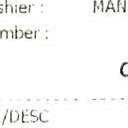

In [89]:
img = Image.open('../data/dataset/croped_images/images/X00016469612_0.jpg')
img

In [249]:
to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.GaussianBlur(3),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.3),
    transforms.Normalize((0.5,), (0.5,)),
])


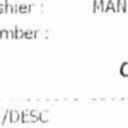

In [248]:
t = to_tensor(img)
Image.fromarray((t[0].numpy()*255).astype(np.uint8))